<a href="https://colab.research.google.com/github/kaneelgit/msi_voxceleb/blob/main/Audio_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import libraries
from urllib.request import urlopen
from zipfile import ZipFile

from IPython.display import HTML
from base64 import b64encode
import matplotlib.pyplot as plt

import os
import glob
import numpy as np
import pandas as pd
import cv2     # for capturing videos
import math
import random

import moviepy.editor as mp
from IPython.display import clear_output

import IPython
import librosa

from scipy.io import wavfile
import os


In [ ]:
#get url
!wget "https://thor.robots.ox.ac.uk/~vgg/data/voxceleb/vox1a/vox2_test_mp4.zip"

--2021-10-11 23:59:54--  https://thor.robots.ox.ac.uk/~vgg/data/voxceleb/vox1a/vox2_test_mp4.zip
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8906971319 (8.3G) [application/zip]
Saving to: ‘vox2_test_mp4.zip’

vox2_test_mp4.zip   100%[===================>]   8.29G  29.0MB/s    in 4m 56s  

2021-10-12 00:04:52 (28.7 MB/s) - ‘vox2_test_mp4.zip’ saved [8906971319/8906971319]



In [ ]:
!unzip vox2_test_mp4.zip

In [2]:
#get video paths
vid_paths = []

for path, directories, files in os.walk('/content/mp4/'):

  for file in files:

    vid_paths.append(str(path) + '/' + str(file))

In [3]:
#number of videos available
print('Number of videos available: ', len(vid_paths))

#shuffle video paths. I have used a random seed of 4 to shuffle.
random.seed(4)
random.shuffle(vid_paths)

Number of videos available:  36237


In [4]:

#some functions to clean the csv file

#del spaces from the ids and gender
def del_spaces(string):
  
  string = string.replace(' ', '')

  return string

#upload csv file from github before running
#open csv file
df = pd.read_csv('/content/vox2_meta.csv')
df.head(5)

#clean the dataset

#apply the function to get rid of spaces
df['VoxCeleb2 ID'] = df['VoxCeleb2 ID'].apply(del_spaces)
df['VGGFace2 ID'] = df['VGGFace2 ID'].apply(del_spaces)
df['Gender'] = df['Gender'].apply(del_spaces)
df['Set'] = df['Set'].apply(del_spaces)


#get the test data
df2 = df[df['Set'] == 'test']
df2['Gender'] = df2['Gender'].astype('category')

df2.head(5)

,VoxCeleb2 ID,VGGFace2 ID,Gender,Set
3,id00017,n000017,m,test
36,id00061,n000061,m,test
53,id00081,n000081,m,test
89,id00154,n000154,m,test
271,id00419,n000419,f,test


In [5]:
#iterate through the vid_paths get the id of the person and get if the person is female or male. If the person is male its a 1 and female its a 0
labels = []

#get only half of the male videos.
count = 0
video_files = []

#iterate
for path in vid_paths:
  
  #get id number
  id_str =  path[13:20]

  #get if the subject is male or female from the csv
  gender = df2.loc[df2['VoxCeleb2 ID'] == str(id_str)]['Gender'].values[0]

  if gender == 'm':
    if count % 2 == 0:
      labels.append(1)
      video_files.append(path)
    count += 1
  
  else:
    labels.append(0)
    video_files.append(path)

In [10]:
#convert from audio to a mel diagram
def aud_to_mel(path):
  
  #get video from path
  video = mp.VideoFileClip(path)
  video = video.subclip(0, 3)

  #get the audio
  x = video.audio.to_soundarray()

  #get audio track to array
  #x = aud.to_soundarray()

  #sampling rate
  fs = 44100
  
  #channel 1
  ch1 = librosa.feature.melspectrogram(x[:, 0], sr = fs)
  mel_ch1 = librosa.amplitude_to_db(ch1, ref = np.min)

  #channel 2
  # ch2 = librosa.feature.melspectrogram(x[:, 1], sr = fs)
  # mel_ch2 = librosa.amplitude_to_db(ch2, ref = np.min)
  
  return mel_ch1.reshape(mel_ch1.shape[0], mel_ch1.shape[1], 1)


In [ ]:
#create a data generator

In [11]:
def audio_generator(paths, labels, batch_size = 16):

  while True:

    #get the number of batches
    number_of_batches = len(paths) // batch_size

    #set up video batches and label batches
    batches = [paths[i : i + batch_size] for i in range(0, len(paths), batch_size)]
    label_batches = [labels[i : i + batch_size] for i in range(0, len(paths), batch_size)]

    for b in range(number_of_batches):

      #create arrays to store the files
      x_batch = np.zeros([batch_size, 128, 259, 1])
      y_batch = np.zeros([batch_size, 1])

      #get the batch
      batch = batches[b]
      label_batch = label_batches[b]

      for i, p in enumerate(batch):
        
        audio_array = aud_to_mel(p)

        #store result
        x_batch[i, :] = audio_array
        y_batch[i, :] = label_batch[i]

      yield {'audio': x_batch}, {'class': y_batch}


In [12]:

#split to train and validation set
train_idx = int(np.floor(len(labels) * 0.9))

#split the train and test data accordingly
train_paths = video_files[:train_idx]
train_labels = labels[:train_idx]

#split the test data
val_paths = video_files[train_idx:]
val_labels = labels[train_idx:]

In [13]:
#validation set
validation_set = np.zeros([150, 128, 259, 1])
validation_labels = np.zeros([150, 1])

#select 100 random indexes from the validation set
#rand_val_idx = np.random.choice(np.arange(len(val_paths)), 150)
rand_val_idx = np.arange(len(val_paths[:150]))

for i, idx in enumerate(rand_val_idx):

  #vid path
  path = val_paths[idx]
  label = val_labels[idx]

  validation_set[i, :] = aud_to_mel(path)
  validation_labels[i, :] = label

<font size = '5'> **CNN MODEL** </font>

In [15]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np
import scipy.misc
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Average, Activation, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout, Concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.python.keras.utils.vis_utils import plot_model

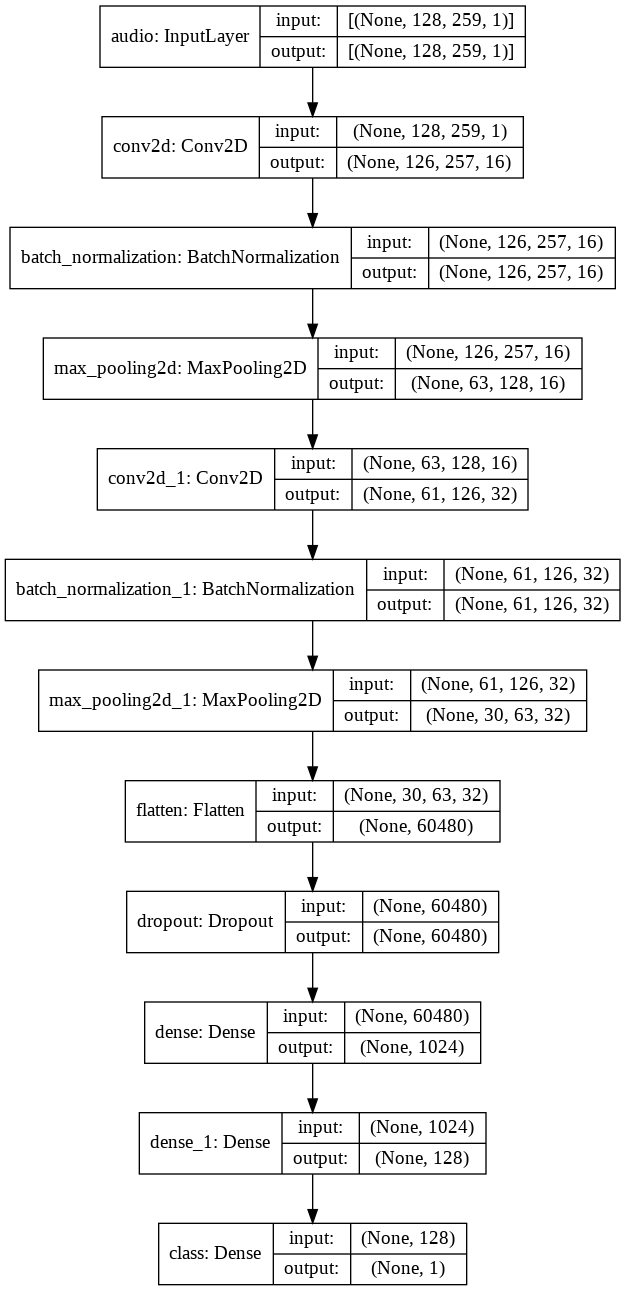

In [16]:
#CNN MODEL
def cnn_model(x):
    
    inputs = x
    x = tf.keras.layers.Conv2D(16, kernel_size = (3, 3),activation = 'relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(pool_size = (2, 2))(x)
    
    x = tf.keras.layers.Conv2D(32, kernel_size = (3, 3), activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(pool_size = (2, 2))(x)
    
    # x = tf.keras.layers.Conv3D(64, kernel_size = (3, 3, 1), activation = 'relu')(x) 
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.MaxPool3D(pool_size = (2, 2, 1))(x)
    
    # x = tf.keras.layers.Conv3D(64, kernel_size = (3, 3, 1), activation = 'relu')(x) 
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.MaxPool3D(pool_size = (2, 2, 1))(x)
   
    return x

#input
input_samp = np.zeros([16, 128, 259, 1])

#input
input = Input(input_samp[0, :].shape, name = 'audio')
out = cnn_model(input)
out = Flatten()(out)
out = Dropout(0.5)(out)
out = Dense(1024, activation = 'relu')(out)
out = Dense(128, activation = 'relu')(out)
output = Dense(1, activation = 'sigmoid', name = 'class')(out)

#create the model
audio_cnn_model = Model(input, output)

#plot the model
plot_model(audio_cnn_model, show_shapes = True, show_layer_names = True, to_file = 'test_model.png')

In [ ]:
#compile the model
opt = tf.optimizers.Adam(0.001)

#learning rate scheduler
def lr_schedule(epoch, lr):
    
    if (epoch + 1) % 5 == 0:
        
        lr *= 0.2
    
    return max(lr, 3e-7)

opt = tf.keras.optimizers.SGD(
    learning_rate=0.01, momentum=0.0, nesterov=False, name='SGD')


#compile model
audio_cnn_model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = 'accuracy')

#callbacks
#create a callback to stop the model when loss get higher
cb = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 5, mode = 'auto')

cb_lr = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

#fit model
history = audio_cnn_model.fit(audio_generator(train_paths, train_labels, batch_size = 8), validation_data = (validation_set, validation_labels),\
                    epochs = 10, steps_per_epoch = 100, callbacks = [cb])

Epoch 1/10
191/200 [===========================>..] - ETA: 2:13 - loss: 0.5253 - accuracy: 0.8007